# Artificial Neural Networks and Deep Learning

## Homework 1
---

## Synapses
Federico Arcelaschi, Giacomo Delera, Andrea Varesi, Paolo Riva \\



## ⚙️ Import Libraries

In [7]:
# # correct version of tensorflow for submission
# %%capture
# %pip uninstall -y tensorflow keras
# %pip install tensorflow==2.17.0 keras==3.4.1

In [8]:
# To get access to Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


In [9]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)
print(tf.keras.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1
3.5.0


## ⏳ Load the Data

In [10]:
# Load the data
data = np.load("augmented_cutmixup_dataset.npz")

In [11]:
# Inspect files of the dataset
print(data.files)

['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']


In [12]:
# Assign each loaded array to the corresponding variable
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [13]:
# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

# Display the shapes of the resulting datasets
print("Training set shape (images):", X_train.shape)
print("Training set shape (labels):", y_train.shape)
print("Validation set shape (images):", X_val.shape)
print("Validation set shape (labels):", y_val.shape)
print("Testing set shape (images):", X_test.shape)
print("Testing set shape (labels):", y_test.shape)

Training set shape (images): (66969, 96, 96, 3)
Training set shape (labels): (66969, 8)
Validation set shape (images): (3588, 96, 96, 3)
Validation set shape (labels): (3588, 8)
Testing set shape (images): (3588, 96, 96, 3)
Testing set shape (labels): (3588, 8)


## 🔎 Inspect Data


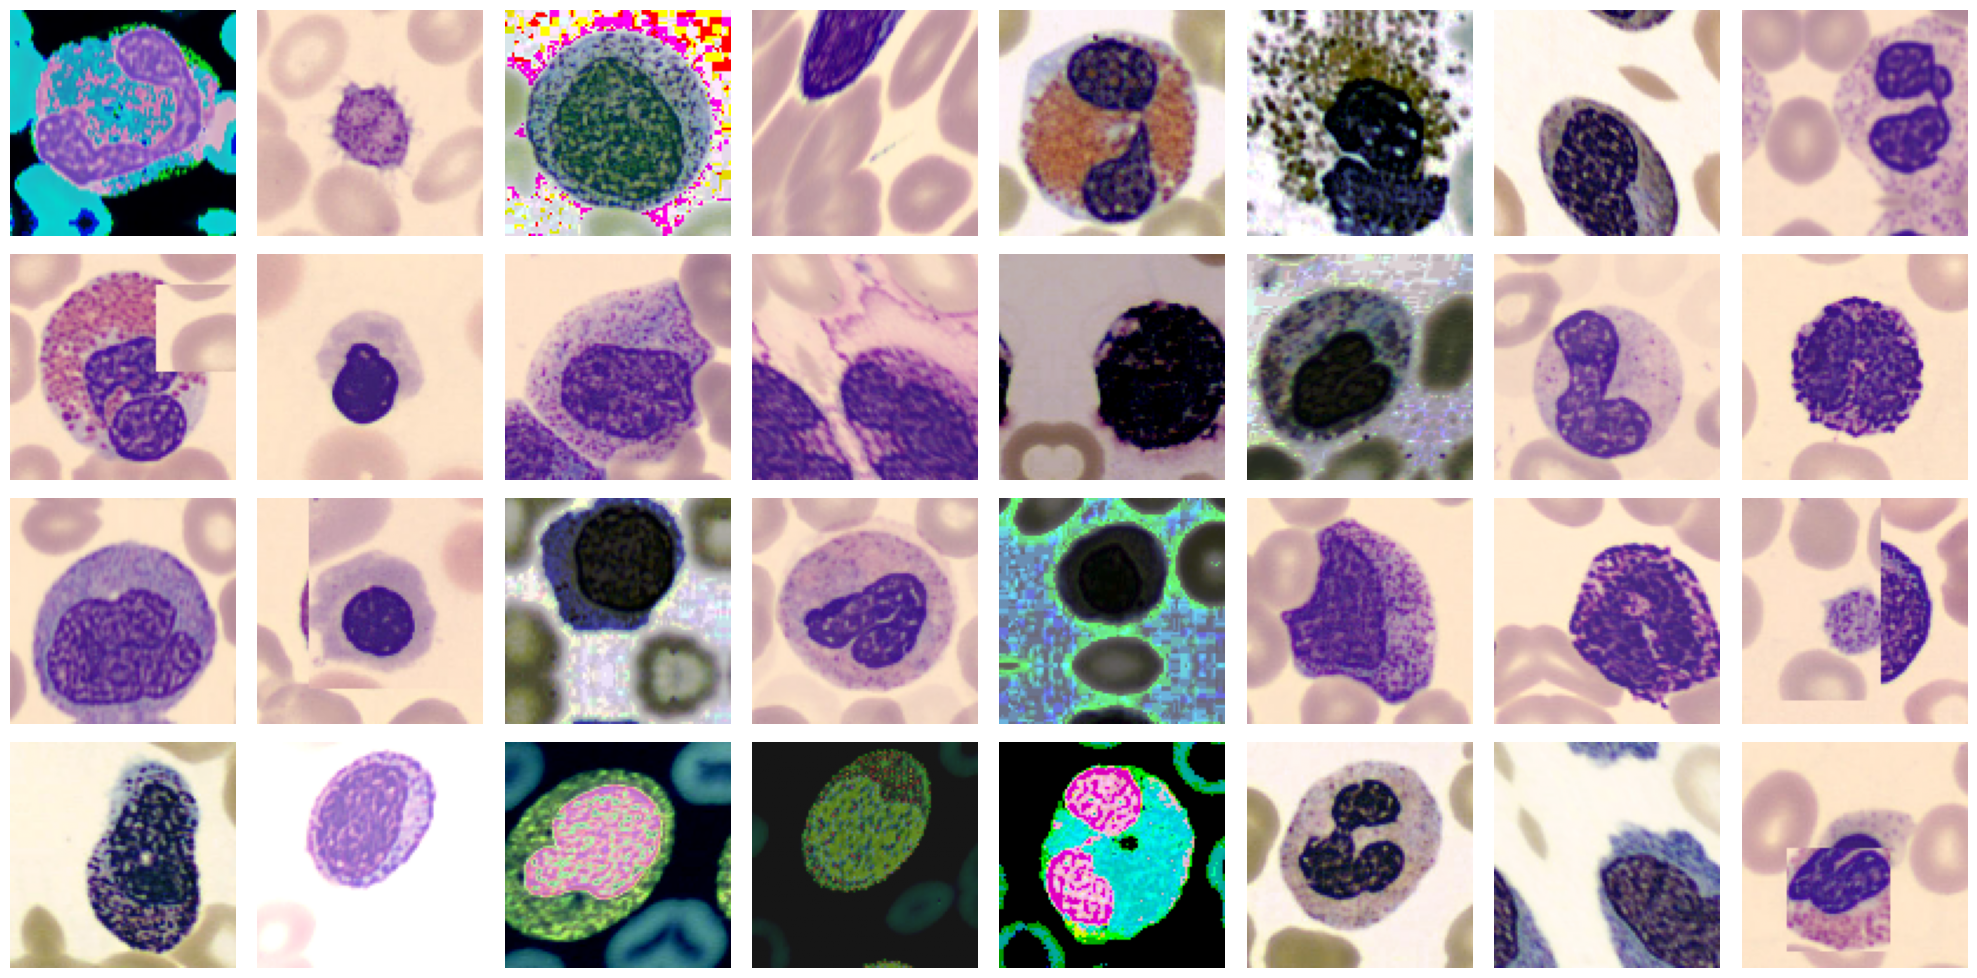

In [14]:
# Number of images to display
num_img = 32
images_per_row = 8  # Number of images per row
random_indices = random.sample(range(len(X_train)), num_img)

# Calculate the number of rows needed (ceil division ensures proper grid size)
num_rows = (num_img + images_per_row - 1) // images_per_row

# Create a subplot grid
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 10))  # Adjust figsize for better proportions

# Flatten axes for easier indexing
axes = axes.flatten()

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(X_train[idx]/255, vmin=0., vmax=1.)
    ax.axis('off')

# Turn off unused axes if the grid is larger than the number of images
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## 🧠 Transfer Learning

In [15]:
# Optimize memory and execution speed
from tensorflow.keras.mixed_precision import set_global_policy, Policy
policy = Policy('mixed_float16')
set_global_policy(policy)

In [16]:
# Define pretrained model
pretrained_model_name = 'efficientnetv2-s'

In [17]:
# Initialize NN model without pretrained weights, for custom training
pretrained_model = tfk.applications.EfficientNetV2S(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
    #pooling='avg',
)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Freeze all layers in EfficientNetV2S to use it solely as a feature extractor
pretrained_model.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Apply data resizing for training robustness
reshape = tf.keras.Sequential([
    tfkl.Resizing(300,300),
    ], name='preprocessing')
inputs = inputs / 255.0
x = reshape(inputs)

# Pass inputs directly to EfficientNetV2S feature extractor without augmentation layer in the model
x = pretrained_model(x)

# Add a dropout layer for regularisation
x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)
x = tfkl.Dense(units=512, activation='relu', kernel_initializer='he_uniform')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(1/6)(x)

x = tfkl.Dense(units=256, activation='relu', kernel_initializer='he_uniform')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(1/6)(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='output_dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
optimizer = tfk.optimizers.AdamW(learning_rate=1e-5)
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1), optimizer=optimizer, metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [19]:
# Train the model
tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        reduce_lr
    ]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'EfficientNetV2S_TL_' + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/200
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 129s 72ms/step - accuracy: 0.2866 - loss: 2.2950 - val_accuracy: 0.7029 - val_loss: 1.2816 - learning_rate: 1.0000e-05
Epoch 2/200
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5764 - loss: 1.5107 - val_accuracy: 0.7790 - val_loss: 1.1507 - learning_rate: 1.0000e-05
Epoch 3/200
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.6616 - loss: 1.3269 - val_accuracy: 0.7957 - val_loss: 1.0962 - learning_rate: 1.0000e-05
Epoch 4/200
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.7003 - loss: 1.2437 - val_accuracy: 0.8091 - val_loss: 1.0655 - learning_rate: 1.0000e-05
Epoch 5/200
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.7270 - loss: 1.1836 - val_accuracy: 0.8219 - val_loss: 1.0417 - learning_rate: 1.0000e-05
Epoch 6/200
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.7420 - loss: 1.1454 - val_accuracy: 0.8305 - val_loss: 1.0257 - learning_rate: 1.0000e-05
Epoch 7/200
1047/1047 ━━━━━━━━━━━

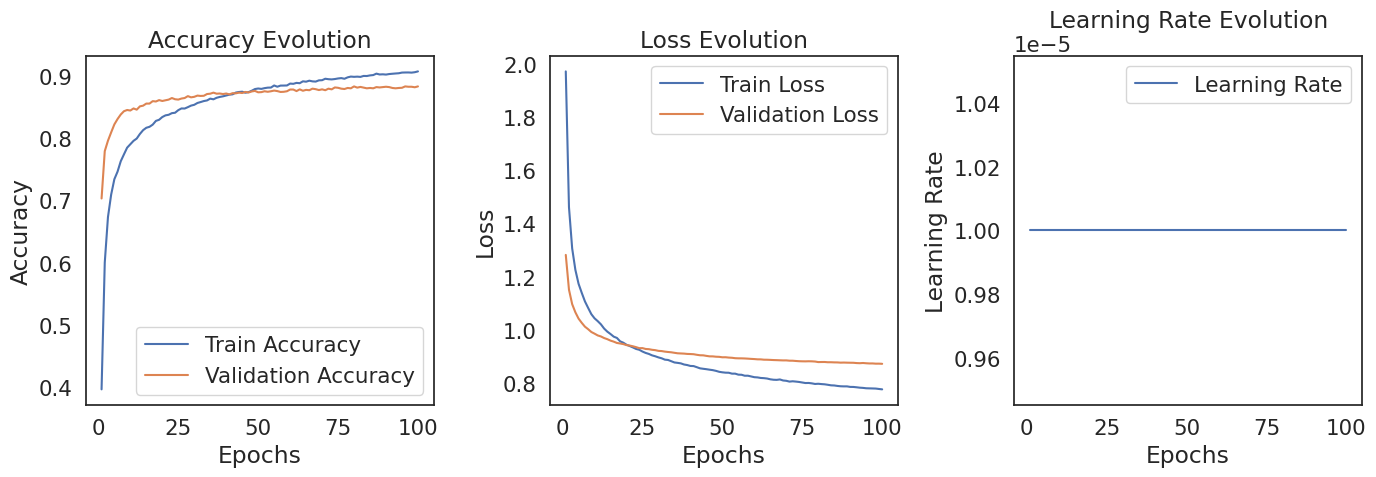

In [21]:
accuracy = tl_history['accuracy']
val_accuracy = tl_history['val_accuracy']
loss = tl_history['loss']
val_loss = tl_history['val_loss']
lr = tl_history['learning_rate']

epochs = range(1, len(accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot learning rate
if lr is not None:
    plt.subplot(1, 3, 3)
    plt.plot(epochs, lr, label='Learning Rate')
    plt.title('Learning Rate Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()

plt.tight_layout()
plt.show()


## 🛠️ Fine Tuning


In [24]:
import tensorflow as tf
from tensorflow.keras import models

# Load the saved model after transfer learning
ft_model = tf.keras.models.load_model(
   'EfficientNetV2S_TL_' + str(final_val_accuracy) + '.keras'
)

# Set the EfficientNet model name
pretrained_model_name = 'efficientnetv2-s'

# Set the EfficientNetV2S model layers as trainable
ft_model.get_layer(pretrained_model_name).trainable = True

# Set all EfficientNetV2S layers as untrainable (freeze)
for layer in ft_model.get_layer(pretrained_model_name).layers:
    layer.trainable = False

# Enable training for Conv2D and DepthwiseConv2D layers only
for i, layer in enumerate(ft_model.get_layer(pretrained_model_name).layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True

# Number of layer to freeze
N = 124

# Set the first N layers as untrainable
for i, layer in enumerate(ft_model.get_layer(pretrained_model_name).layers[:N]):
    layer.trainable = False

# UNCOMMENT TO: Print the index, name and trainability status of each layer
"""
for i, layer in enumerate(ft_model.get_layer(pretrained_model_name).layers):
    print(i, layer.name, layer.trainable)
"""

# Populate the model with training parameters
ft_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=['accuracy']
)

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True), reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'EfficientNetV2S_FT_'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/200
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 238s 69ms/step - accuracy: 0.9089 - loss: 0.3542 - val_accuracy: 0.8899 - val_loss: 0.4175 - learning_rate: 1.0000e-04
Epoch 2/200
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - accuracy: 0.9471 - loss: 0.2102 - val_accuracy: 0.8913 - val_loss: 0.3822 - learning_rate: 1.0000e-04
Epoch 3/200
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - accuracy: 0.9546 - loss: 0.1746 - val_accuracy: 0.8905 - val_loss: 0.3840 - learning_rate: 1.0000e-04
Epoch 4/200
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - accuracy: 0.9575 - loss: 0.1591 - val_accuracy: 0.8891 - val_loss: 0.3613 - learning_rate: 1.0000e-04
Epoch 5/200
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 78s 37ms/step - accuracy: 0.9635 - loss: 0.1436 - val_accuracy: 0.9044 - val_loss: 0.3437 - learning_rate: 1.0000e-04
Epoch 6/200
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - accuracy: 0.9642 - loss: 0.1367 - val_accuracy: 0.9038 - val_loss: 0.3484 - learning_rate: 1.0000e-04
Epoch 7/200
2093/2093 ━━━━━━━━━━━

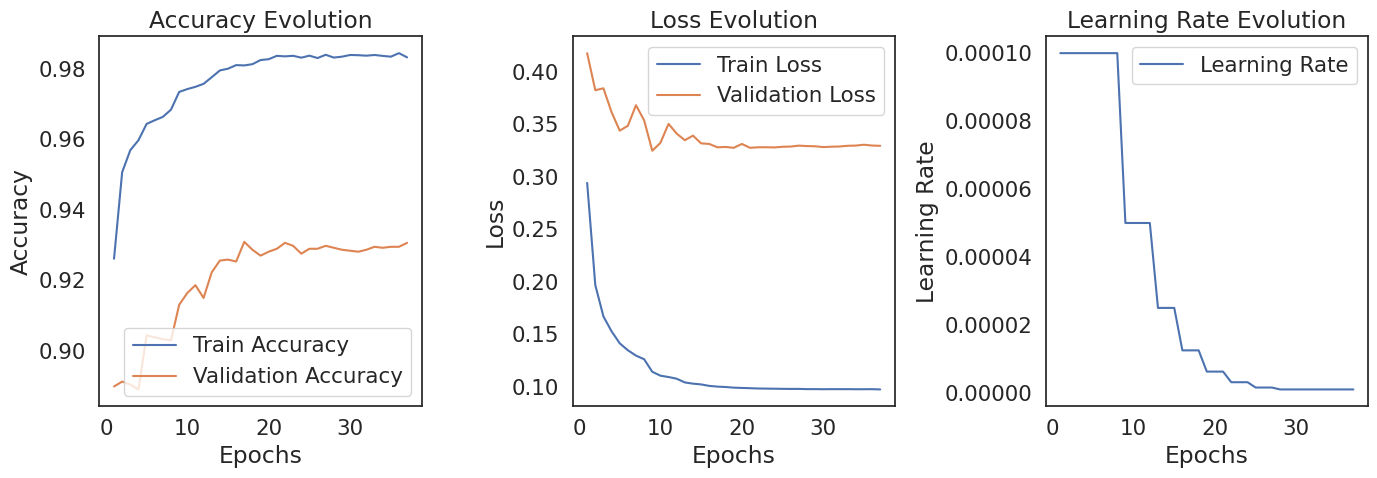

In [ ]:
accuracy = ft_history['accuracy']
val_accuracy = ft_history['val_accuracy']
loss = ft_history['loss']
val_loss = ft_history['val_loss']
lr = ft_history['learning_rate']

epochs = range(1, len(accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot learning rate
if lr is not None:
    plt.subplot(1, 3, 3)
    plt.plot(epochs, lr, label='Learning Rate')
    plt.title('Learning Rate Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()

plt.tight_layout()
plt.show()


## Test the model

In [ ]:
# Save the final model to be eligible for "test_time_aug_and_zip.ipynb" and submission
model = tfk.models.load_model('EfficientNetV2S_FT_'+str(final_val_accuracy)+'.keras')

In [ ]:
y_pred = model.predict(X_test)
accuracy = (np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)).sum() / len(y_test)

print(f"Test accuracy: {accuracy:.2f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step
Test accuracy: 0.93


## 📦 Save the model

In [ ]:
model.save('weights.keras')
del model